In [43]:
from proxbias.depmap.process import compute_monte_carlo_stats
from proxbias.depmap.load import get_depmap_data
from proxbias.utils.data_utils import get_cancer_gene_lists
from proxbias.metrics import genome_proximity_bias_score
from proxbias.depmap.constants import *

In [44]:
import os
import sys

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import pickle
import ast
import random

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [45]:
crispr_effect, _, cnv_data, mutation_data = get_depmap_data(rnai_release="")
oncogenes, tsgs = get_cancer_gene_lists(crispr_effect.index)

CRISPRGeneEffect.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsCNGene.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!
OmicsSomaticMutations.csv from DepMap Public 22Q4 is found. Reading dataframe from cache.
Done!


In [48]:
permuted_null=pd.read_csv("p53_wt_permuted_null_LOF_genes.txt", sep="\t")
permuted_null.query('result_type=="observed"')

,Unnamed: 0,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value
1,0,BTG2,"[0.6002375000000001, 0.5976874999999999, 0.590...",0.598093,"[0.5599500000000001, 0.5649124999999999, 0.544...",0.568502,0.029590,lof,20,32,439,42,observed,16.257404,3.202226e-41
1002,1,CDKN2A,"[0.603825, 0.566475, 0.618375, 0.5808875, 0.56...",0.582039,"[0.5859624999999999, 0.5670125, 0.5693625, 0.5...",0.559336,0.022703,lof,20,416,225,42,observed,12.272333,1.702478e-27
2003,2,CDKN2B,"[0.6345375, 0.5713124999999999, 0.6119375, 0.5...",0.584120,"[0.5652625, 0.556325, 0.5588124999999999, 0.55...",0.558278,0.025842,lof,20,398,278,42,observed,14.022306,1.804475e-33
3004,3,CDKN2C,"[0.5956999999999999, 0.5944875000000001, 0.581...",0.579267,"[0.5884625, 0.5666625, 0.558575, 0.59581250000...",0.570129,0.009138,lof,20,68,514,42,observed,5.462087,1.120683e-07
4005,4,MDM2,"[0.5913625, 0.567975, 0.5862124999999999, 0.57...",0.589886,"[0.5613625, 0.5856999999999999, 0.573637499999...",0.572725,0.017161,lof,20,29,544,42,observed,10.093966,2.310054e-20
5006,5,MDM4,"[0.6002375000000001, 0.5976874999999999, 0.590...",0.598093,"[0.5777375, 0.567425, 0.5828874999999999, 0.57...",0.570926,0.027166,lof,20,32,426,42,observed,15.819283,1.065148e-39


In [49]:
count_value_less_than_0_05 = permuted_null[(permuted_null['p_value'] < 0.05) & (permuted_null['result_type'] == "empirical_null")].shape[0]
count_empirical_null = permuted_null[permuted_null['result_type'] == "empirical_null"].shape[0]

print("Number of rows with p_value < 0.05 and result_type == 'empirical_null':", count_value_less_than_0_05)
print("Total number of rows where result_type == 'empirical_null':", count_empirical_null)

Number of rows with p_value < 0.05 and result_type == 'empirical_null': 4051
Total number of rows where result_type == 'empirical_null': 6000


In [50]:
#write a function that adds empirical p-values to the dataframe
def calculate_empirical_p_value(df, diff_col='diff', result_type_col='result_type', gene_col='gene', null_type='empirical_null'):
    # Filter out the empirical null result types for calculating p-values
    empirical_df = df[df[result_type_col] == null_type]

    # Group by gene
    grouped = empirical_df.groupby(gene_col)

    # Function to calculate two-sided empirical p-values within each group
    def emp_p_value(diff, group):
        null_diffs = group[diff_col].values
        abs_diff = abs(diff)
        count = np.sum(np.abs(null_diffs) >= abs_diff)
        p_value = count / len(group)
        return p_value

    # Initialize a column for empirical p-values
    df['empirical_p_value'] = np.nan

    # Iterate through each row in the dataframe
    for idx, row in df.iterrows():
        gene_group = grouped.get_group(row[gene_col])
        df.at[idx, 'empirical_p_value'] = emp_p_value(row[diff_col], gene_group)
    
    return df

test = calculate_empirical_p_value(permuted_null)
test.sort_values('empirical_p_value').query("result_type=='observed'")



,Unnamed: 0,gene,test_stats,test_mean,wt_stats,wt_mean,diff,search_mode,n_models,n_test,n_wt,seed,result_type,t_stat,p_value,empirical_p_value
1002,1,CDKN2A,"[0.603825, 0.566475, 0.618375, 0.5808875, 0.56...",0.582039,"[0.5859624999999999, 0.5670125, 0.5693625, 0.5...",0.559336,0.022703,lof,20,416,225,42,observed,12.272333,1.702478e-27,0.000
2003,2,CDKN2B,"[0.6345375, 0.5713124999999999, 0.6119375, 0.5...",0.584120,"[0.5652625, 0.556325, 0.5588124999999999, 0.55...",0.558278,0.025842,lof,20,398,278,42,observed,14.022306,1.804475e-33,0.000
1,0,BTG2,"[0.6002375000000001, 0.5976874999999999, 0.590...",0.598093,"[0.5599500000000001, 0.5649124999999999, 0.544...",0.568502,0.029590,lof,20,32,439,42,observed,16.257404,3.202226e-41,0.014
5006,5,MDM4,"[0.6002375000000001, 0.5976874999999999, 0.590...",0.598093,"[0.5777375, 0.567425, 0.5828874999999999, 0.57...",0.570926,0.027166,lof,20,32,426,42,observed,15.819283,1.065148e-39,0.024
4005,4,MDM2,"[0.5913625, 0.567975, 0.5862124999999999, 0.57...",0.589886,"[0.5613625, 0.5856999999999999, 0.573637499999...",0.572725,0.017161,lof,20,29,544,42,observed,10.093966,2.310054e-20,0.159
3004,3,CDKN2C,"[0.5956999999999999, 0.5944875000000001, 0.581...",0.579267,"[0.5884625, 0.5666625, 0.558575, 0.59581250000...",0.570129,0.009138,lof,20,68,514,42,observed,5.462087,1.120683e-07,0.268


/Users/gen-omix/Documents/proxbias/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gen-omix/Documents/proxbias/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


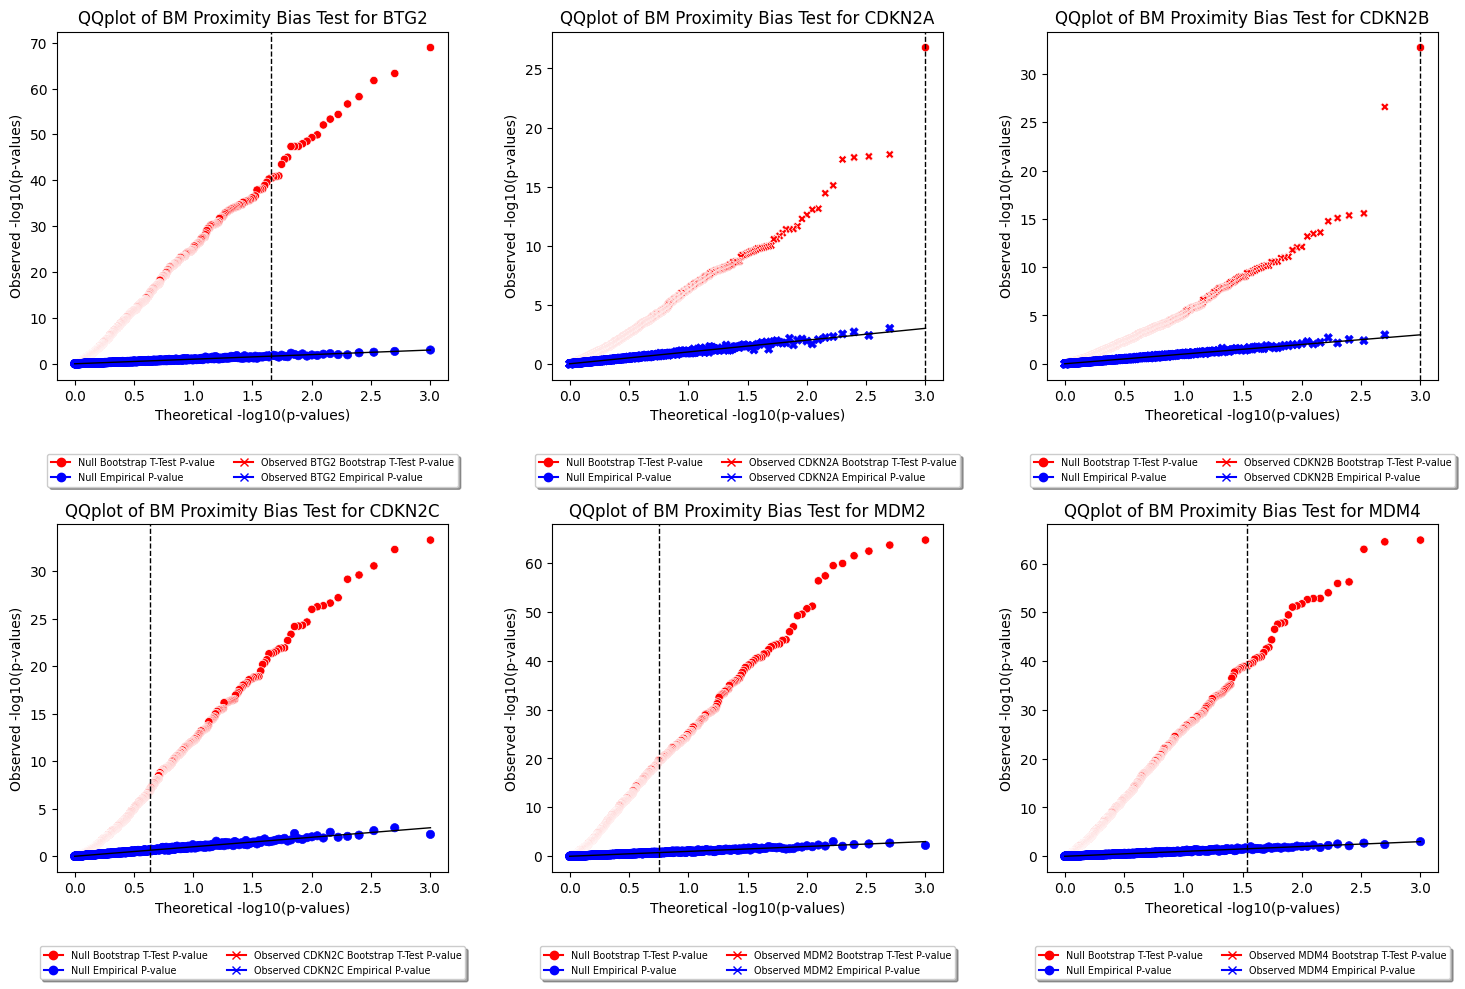

In [51]:
# Function to create QQ plot
def qq_plot(df, gene_name, ax=None):
    # Ensure the p-values are sorted for plotting
    df = df.sort_values(by='p_value')

    # Calculate theoretical quantiles
    df['theoretical'] = -np.log10((np.arange(1, len(df) + 1) / (len(df) + 1)))

    # Use provided ax if given, otherwise create new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.get_figure()

    # Scatter plot for p_value
    sns.scatterplot(x='theoretical', y=-np.log10(df['p_value']), c="red",
                    style='result_type', data=df, marker='o', ax=ax)

    # Scatter plot for empirical_p_value
    sns.scatterplot(x='theoretical', y=-np.log10(df['empirical_p_value']), c="blue",
                    style='result_type', data=df, marker='x', ax=ax)

    # Plot the diagonal line
    ax.plot([df['theoretical'].min(), df['theoretical'].max()],
            [df['theoretical'].min(), df['theoretical'].max()],
            color='black', linestyle='-', linewidth=1)
    
    # Draw a horizontal line at the observed value
    gene_data = df[df['result_type'] == "observed"]
    observed_theoretical = gene_data['theoretical'].values[0]
    ax.axvline(x=observed_theoretical, color='black', linestyle='--', linewidth=1, label='Observed Gene P-value')

    # Labels and title
    ax.set_xlabel('Theoretical -log10(p-values)')
    ax.set_ylabel('Observed -log10(p-values)')
    ax.set_title(f'QQplot of BM Proximity Bias Test for {gene_name}')

    # Custom legend below the plot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='red', label='Null Bootstrap T-Test P-value'),
        Line2D([0], [0], marker='o', color='blue', label='Null Empirical P-value'),
        Line2D([0], [0], marker='x', color='red', label=f'Observed {gene_name} Bootstrap T-Test P-value'),
        Line2D([0], [0], marker='x', color='blue', label=f'Observed {gene_name} Empirical P-value')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=True, ncol=2, fontsize='x-small')

    return fig, ax

def faceted_qq_plots(df):
    genes = df['gene'].unique()  # Get unique gene names from the dataframe
    num_genes = len(genes)
    num_cols = 3  # Number of columns in the grid layout
    num_rows = (num_genes + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i, gene in enumerate(genes):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]
        gene_data = df[df['gene'] == gene]
        qq_plot(gene_data, gene, ax=ax)

    # Remove empty plots
    for i in range(len(genes), num_rows*num_cols):
        row = i // num_cols
        col = i % num_cols
        if num_rows > 1:
            fig.delaxes(axes[row, col])
        else:
            fig.delaxes(axes[col])

    plt.tight_layout()
    plt.show()

# Example usage:
faceted_qq_plots(test)


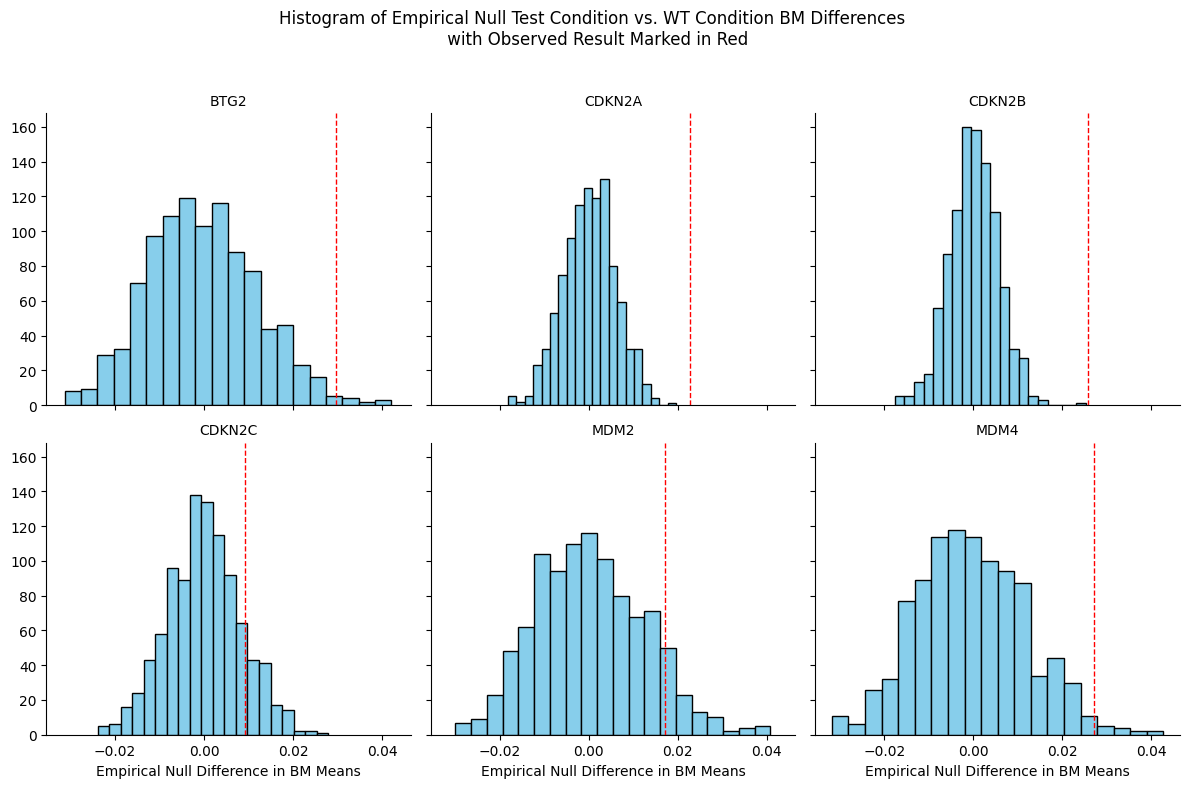

In [52]:
def plot_empirical_null_histogram(df, gene_column='gene'):
    """
    Plot histograms of 'empirical_null' diff values faceted by gene,
    with observed values marked by vertical red lines if they exist.

    Parameters:
    - df: pandas DataFrame containing the data
    - gene_column: name of the column to use for grouping (default: 'gene')

    Returns:
    - None (displays the plot)
    """
    # Filter data for "empirical_null" result_type
    df_empirical_null = df[df['result_type'] == 'empirical_null']

    # Find genes with "observed" values
    genes_with_observed = df[df['result_type'] == 'observed'][gene_column].unique()

    # Filter the empirical null data to only include genes with observed values
    df_empirical_null = df_empirical_null[df_empirical_null[gene_column].isin(genes_with_observed)]

    # FacetGrid with seaborn
    g = sns.FacetGrid(df_empirical_null, col=gene_column, col_wrap=3, height=4)

    # Plot histogram for each gene
    g.map(plt.hist, 'diff', bins=20, color='skyblue', edgecolor='black')

    # Add a vertical red line for the "observed" value in each facet
    for ax, gene in zip(g.axes.flat, df_empirical_null[gene_column].unique()):
        observed_diff = df[(df[gene_column] == gene) & (df['result_type'] == 'observed')]['diff'].values[0]
        ax.axvline(x=observed_diff, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('Empirical Null Difference in BM Means')

    # Adjust layout and display plot
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Histogram of Empirical Null Test Condition vs. WT Condition BM Differences \n with Observed Result Marked in Red')
    plt.show()

# Example usage:
# Assuming df is your pandas DataFrame with the provided data
plot_empirical_null_histogram(permuted_null, gene_column='gene')
